# Example 1.1: What is random vibrations?
In this example, we will discuss how stochastic vibrations are different from deterministic vibrations. The stochastic behaviour of a linear dynamic system originates from the uncertainty of the dynamic loads. If we do not know the loads, we do not know the response either. 

This situation is not different from what we are used to from static analysis since we rarely know the static loads precisely. We instead use what we know about the statistical properties of the static loads to determine design loads with a selected annual probability of exceedance. This approach is possible since the largest static loads will give the largest static response and associated load effect.  

We use a similar approach when designing structures subjected to uncertain dynamic loads. Still, since the response depends on the instantaneous load and the load history, we need to use an approach where the load history and thus dynamic magnification are considered.

This example will consider a simple two degree of freedom system subjected to deterministic (known) and stochastic (uncertain) loads. The example illustrates how stochastic and deterministic dynamic loads and vibrations are different.

In [3]:
# Import necessary packages and modules
import numpy as np
from scipy.linalg import eig
import sys
sys.path.append('./../modules')
from time_integration import * # Import all functions in the module time_integration
from matplotlib import pyplot as plt 

## Define structural properties
We start by defining the structural properties of a two-degree of freedom dynamic system

$\mathbf{M} \ddot{\mathbf{y}} + \mathbf{C} \dot{\mathbf{y}} + \mathbf{K} \mathbf{y} = \mathbf{X}(t) $

In [4]:
# Define structural properties
m = 1.0 # Mass of each story
k = 100.0 # Stiffness
MM = np.eye(2)*m # Mass matrix
KK = np.array(([[2, -1], [-1, 1]]))*k # Stiffness matrix

we then calculate the natural frequencies and mode shapes by solving the generalized eigenvalue problem.

$ \left( \mathbf{K} - \lambda \mathbf{M} \right) \Phi = \mathbf{0} $

In [5]:
# Calculate modes and frequencies
lam,v = eig(KK,MM) #Solve eigenvalue problem using scipy 
#lam = np.reshape(lam, (1, lam.shape[0]))
v[:,0] = v[:,0]/np.max(v[:,0]) #Normalize the eigenvector
v[:,1] = v[:,1]/np.max(v[:,1])
f = np.real(lam)**0.5/2/np.pi #Natural frequencies in Hz
omega = f*2*np.pi # Natural frequencies in rad/s

We assume thet the damping can be modelled using Rayleigh damping and assign 5 per cent damping for the two vibration modes. Since we only have two degrees of freedom this means that we get the two damping ratios that we assign for the two modes. Rayleigh damping is defined as

$\mathbf{C} = \alpha_1 \mathbf{M} + \alpha_2 \mathbf{K} $

The factors $\alpha_1$ and $\alpha_2$ are defined as

$ \alpha_1 = 2\omega_1\omega_2 \frac{\left(\zeta_2\omega_1-\zeta_1\omega_2 \right)} {\omega_1^2-\omega_2^2} $

$ \alpha_2 = 2 \frac{\zeta_1 \omega_1 -\zeta_2\omega_2}{\omega_1^2-\omega_2^2}    $


In [6]:
# Rayleigh damping
zeta = np.array(([5.0, 5.0]))/100
alpha1 = 2*omega[0]*omega[1]*(zeta[1]*omega[0]-zeta[0]*omega[1])/(omega[0]**2-omega[1]**2)
alpha2 = 2*(zeta[0]*omega[0]-zeta[1]*omega[1])/(omega[0]**2-omega[1]**2)
CC = alpha1*MM + alpha2*KK

## Dynamic response due to determenistic harmonic loads
We then calculate the resposne of the two degree of freedom system subjected to a harmonic load. We solve the dynamic response by Newmark time integration.

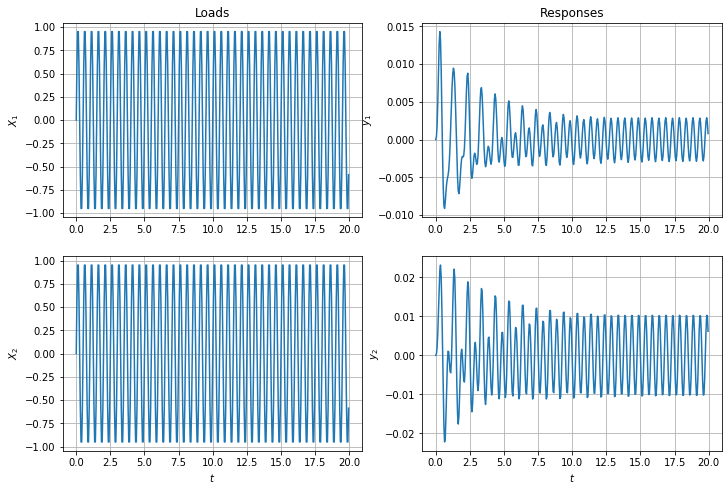

In [13]:
h = 0.05 #Time step
t = np.arange(0.,20.,h) # Time vector
fl = 2.0 # Load frequency
po = 100.0 # Load amplitude
u0 = np.array([[0.0], [0.0]]) #Initial displacement
udot0 = np.array([[0.0], [0.0]]) # Initial velocity
beta = 1.0/4.0 # Facor in Newmark's method
gamma = 1.0/2.0 # Factor in Newmark's method
X = np.vstack((np.sin(2.0*np.pi*fl*t),np.sin(2.0*np.pi*fl*t)))
y, ydot, y2dot = linear_newmark_krenk(MM,CC,KK,X,u0,udot0,h,gamma,beta)

# Plot deterministic dynamic load and response
cm = 1/2.54  # centimeters in inches
fig, axs = plt.subplots(2,2,figsize=(30*cm, 20*cm))
axs[0,0].plot(t, X[0,:])
axs[0,0].set_ylabel('$X_1$')
axs[0,0].set_title('Loads')
axs[0,0].grid(True)

axs[1,0].plot(t, X[1,:])
axs[1,0].set_ylabel('$X_2$')
axs[1,0].set_xlabel('$t$')
axs[1,0].grid(True)


axs[0,1].plot(t, y[0,:])
axs[0,1].set_ylabel('$y_1$')
axs[0,1].set_title('Responses')
axs[0,1].grid(True)

axs[1,1].plot(t, y[1,:])
axs[1,1].set_ylabel('$y_2$')
axs[1,1].set_xlabel('$t$')
axs[1,1].grid(True)

We observe that the structure starts from rest and that there is a transient response that lasts for about 10 seconds until the structure reaches a steady-state dynamic response. Since the loads are determenistic (known) the response will be perfectly the same each time we solve it.

## Dynamic response due to stochastic loads

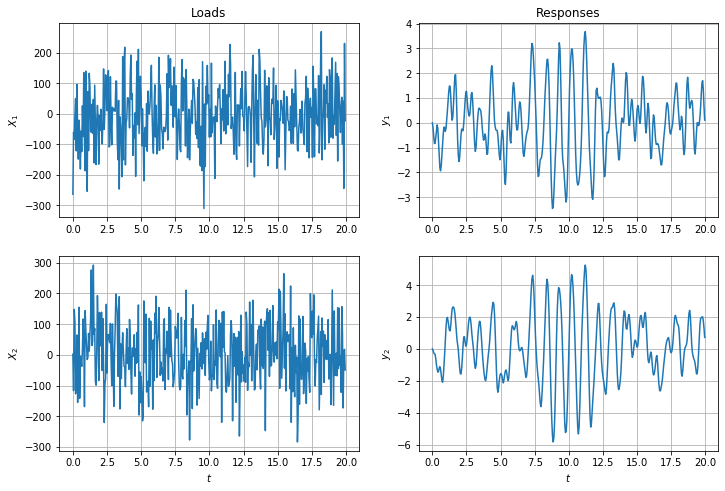

In [43]:
rho_X1_X2 = 0.1 # Load correlation coefficient
stdX1 = 100.0 # Standard deviation X1
stdX2 = 100.0 # Standard deviation X2

covmX = np.array(([[stdX1**2, rho_X1_X2*stdX1*stdX2], [rho_X1_X2*stdX1*stdX2, stdX2**2]])) # Covariance matrix of the loads
lam,v = eig(covmX) #Solve eigenvalue problem using scipy 
covmX_modal = np.matmul(np.matmul(v.T,covmX),v) # Transform covariance matrix to uncorrelated space

U = np.vstack((np.random.normal(0, covmX_modal[0,0]**0.5, t.shape[0]),np.random.normal(0, covmX_modal[1,1]**0.5, t.shape[0])))
X = np.matmul(v,U) # Transform to correlated space

y, ydot, y2dot = linear_newmark_krenk(MM,CC,KK,X,u0,udot0,h,gamma,beta)

# Plot stochastic dynamic load and response
cm = 1/2.54  # centimeters in inches
fig, axs = plt.subplots(2,2,figsize=(30*cm, 20*cm))
axs[0,0].plot(t, X[0,:])
axs[0,0].set_ylabel('$X_1$')
axs[0,0].set_title('Loads')
axs[0,0].grid(True)

axs[1,0].plot(t, X[1,:])
axs[1,0].set_ylabel('$X_2$')
axs[1,0].set_xlabel('$t$')
axs[1,0].grid(True)


axs[0,1].plot(t, y[0,:])
axs[0,1].set_ylabel('$y_1$')
axs[0,1].set_title('Responses')
axs[0,1].grid(True)

axs[1,1].plot(t, y[1,:])
axs[1,1].set_ylabel('$y_2$')
axs[1,1].set_xlabel('$t$')
axs[1,1].grid(True)


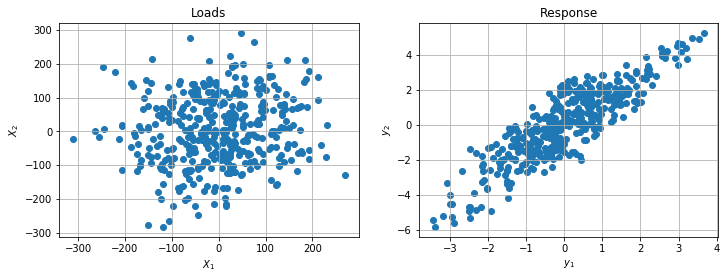

In [44]:
# Plot scatter plot of dynamic loads and response
fig, axs = plt.subplots(1,2,figsize=(30*cm, 10*cm))
axs[0].scatter(X[0,:],X[1,:])
axs[0].set_ylabel('$X_2$')
axs[0].set_xlabel('$X_1$')
axs[0].set_title('Loads')
axs[0].grid(True)

axs[1].scatter(y[0,:],y[1,:])
axs[1].set_ylabel('$y_2$')
axs[1].set_xlabel('$y_1$')
axs[1].set_title('Response')
axs[1].grid(True)
